# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 1

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`.

In [3]:
cigData = pd.read_csv('CowboyCigsData.csv')
cigData_decompose = pd.read_csv('CowboyCigsData.csv')

In [4]:
cigData.info(); print(); cigData.describe(); print(); cigData.head(13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB




,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121
5,5,1949-06,1000135
6,6,1949-07,1000148
7,7,1949-08,1000148
8,8,1949-09,1000136
9,9,1949-10,1000119


In [5]:
cigData.drop(['Unnamed: 0'], inplace=True, axis=1)
cigData_decompose.drop(['Unnamed: 0'], inplace=True, axis=1)

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

It doesn't conduce.

In [6]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand.

In [7]:
cigData.rename({'#CigSales':'Sales'}, axis=1, inplace=True)
cigData_decompose.rename({'#CigSales':'Sales'}, axis=1, inplace=True)

cigData.rename({'Time':'Months'}, axis=1, inplace=True)
cigData_decompose.rename({'Time':'Months'}, axis=1, inplace=True)

In [8]:
cigData_decompose.head()

,Months,Sales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


In [9]:
cigData.head()

,Months,Sales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


In [10]:
cigData['Months'] = pd.to_datetime(cigData['Months'])

In [11]:
cigData['Sales'].sum()

144040363

In [12]:
cigData.isnull().values.any()

False

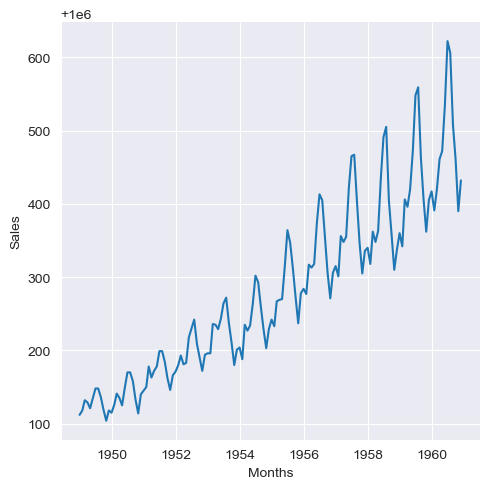

In [13]:
sns.relplot(x='Months', y="Sales", data=cigData, kind="line")

In [14]:
cigData.set_index('Months', inplace=True)

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column.

In [15]:
cigData.head()

,Sales
Months,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [16]:
y = cigData['Sales']

Check the type of our new variable. 

In [17]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [18]:
cigData.describe()

,Sales
count,1.440000e+02
mean,1.000280e+06
std,1.199663e+02
min,1.000104e+06
25%,1.000180e+06
50%,1.000266e+06
75%,1.000360e+06
max,1.000622e+06


## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

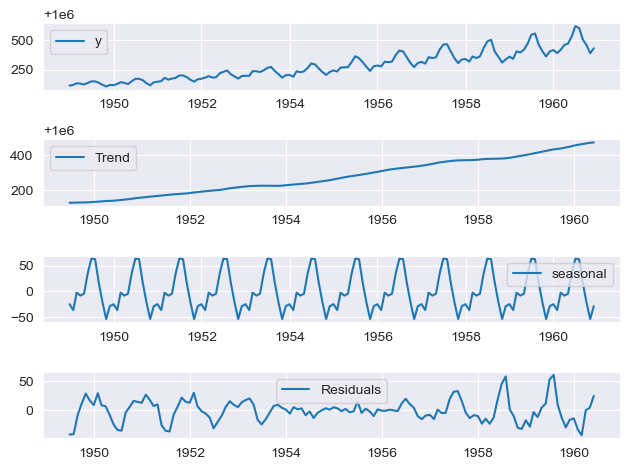

In [19]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'y')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')

plt.tight_layout()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [20]:
from statsmodels.tsa.stattools import kpss
kpss(y)

/Users/jshensley/.conda/envs/DataScienceGuidedCapstone/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

In [21]:
y.head()

Months
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: Sales, dtype: int64

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One oft used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now.

In [22]:
# Declare a variable called y_log
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains constant over time.

In [23]:
y_log.head()

Months
1949-01-01    13.815623
1949-02-01    13.815629
1949-03-01    13.815643
1949-04-01    13.815640
1949-05-01    13.815632
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Months'>

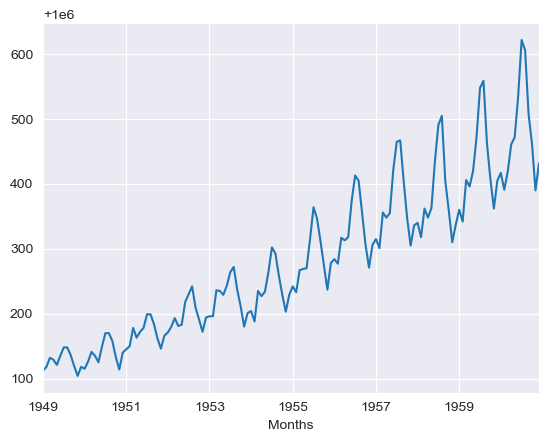

In [24]:
cigData['Sales'].plot()

<AxesSubplot:xlabel='Months'>

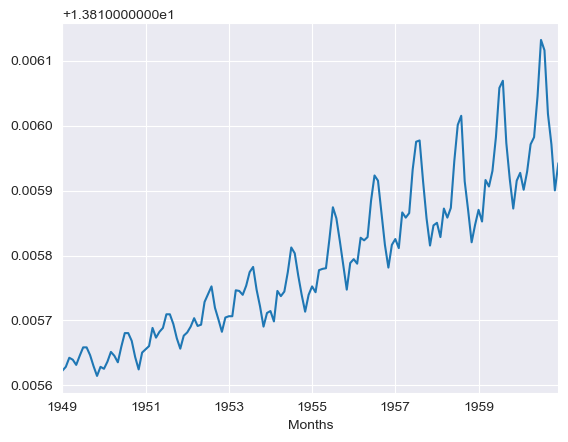

In [25]:
y_log.plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [26]:
kpss(y_log.diff().dropna())

/Users/jshensley/.conda/envs/DataScienceGuidedCapstone/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.023897674207570566,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [27]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels import tsa.SARIMAX

#### 3di. Make a function to find the MSE of a single ARIMA model

In [28]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
# noinspection PyUnusedLocal
def evaluate_arima_model(data,arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()

    split = int(len(data) * 0.8)

    train,test = data[:split], data[split:]
    past = list(train)

    # make predictions
    predictions = []
    for i in range(len(test)):  #timestep-wise comparison between test data and one-step prediction ARIMA model.
    	print(f'i is {i} and i am inside for loop for ARIMA model')
    	model = ARIMA(past,order=arima_order)
    	model_fit = model.fit()

    	future = model_fit.forecast()[0]
    	print(f'future is {future}')

    	predictions.append(future)
    	past.append(test[i])

    print(f'in predictions list {predictions}')
    # calculate out of sample error

    error = mean_squared_error(test,predictions)
    # Return the error
    print(f'error is {error}')
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [29]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
# noinspection TryExceptContinue,PyBroadException
def evaluate_models(dataset,p_values,d_values,q_values):

    best_score, best_cfg = float("inf"), None
    print(f'best_score = {best_score}, best_cfg = {best_cfg}')

    	# Iterate through p_values

    for p in p_values:
        		# Iterate through d_values
        for d in d_values:
            			# Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                print(order)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset,order)
                    if mse < best_score:
                    	print(f'mse {mse} is less than best_score {best_score}')
                    	best_score, best_cfg = mse, order
                    print(f'ARIMA {order} and MSE {mse}')

                except Exception:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg,best_score))

In [30]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [p for p in range(0, 3)]
d_values = [d for d in range(0, 3)]
q_values = [q for q in range(0, 3)]
print(p_values, d_values, q_values, sep='\n\n')


[0, 1, 2]

[0, 1, 2]

[0, 1, 2]


In [31]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)

best_score = inf, best_cfg = None
(0, 0, 0)
i is 0 and i am inside for loop for ARIMA model
future is 13.815745694715426
i is 1 and i am inside for loop for ARIMA model
future is 13.815748002460467
i is 2 and i am inside for loop for ARIMA model
future is 13.815749430378286
i is 3 and i am inside for loop for ARIMA model
future is 13.815750519357529
i is 4 and i am inside for loop for ARIMA model
future is 13.81575106075469
i is 5 and i am inside for loop for ARIMA model
future is 13.815751631497033
i is 6 and i am inside for loop for ARIMA model
future is 13.815752561484558
i is 7 and i am inside for loop for ARIMA model
future is 13.815753345873066
i is 8 and i am inside for loop for ARIMA model
future is 13.815754823144056
i is 9 and i am inside for loop for ARIMA model
future is 13.81575523290108
i is 10 and i am inside for loop for ARIMA model
future is 13.815757254752343
i is 11 and i am inside for loop for ARIMA model
future is 13.815758939662722
i is 12 and i am inside for loop

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [32]:
p=2
d=1
q=1
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)
forecast

1961-01-01    13.815979
1961-02-01    13.816000
1961-03-01    13.816006
1961-04-01    13.816003
1961-05-01    13.815998
1961-06-01    13.815993
1961-07-01    13.815991
1961-08-01    13.815990
1961-09-01    13.815991
1961-10-01    13.815991
1961-11-01    13.815992
1961-12-01    13.815992
1962-01-01    13.815992
1962-02-01    13.815992
1962-03-01    13.815992
1962-04-01    13.815992
1962-05-01    13.815992
1962-06-01    13.815992
1962-07-01    13.815992
1962-08-01    13.815992
1962-09-01    13.815992
1962-10-01    13.815992
1962-11-01    13.815992
1962-12-01    13.815992
Freq: MS, Name: predicted_mean, dtype: float64

In [33]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1287.245
Date:                Tue, 25 Oct 2022   AIC                          -2566.490
Time:                        12:54:20   BIC                          -2554.639
Sample:                    01-01-1949   HQIC                         -2561.674
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575   1.33e-19   7.98e+18      0.000       1.057       1.057
ar.L2         -0.4391   7.17e-19  -6.12e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.89e-20  -1.82e+19      0.0

We can take a look at a summary of the model this library has built around our data.

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

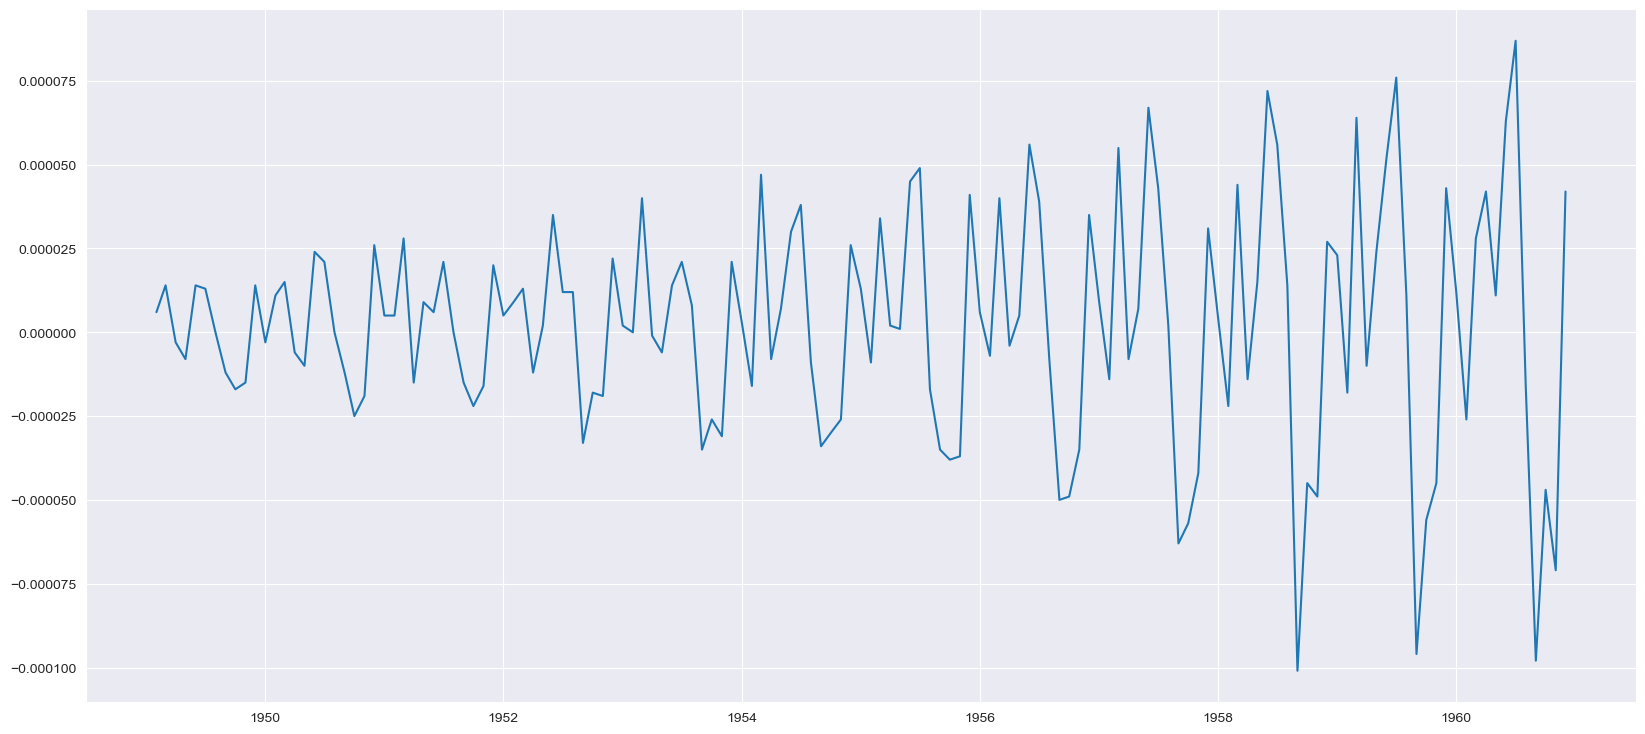

In [34]:
plt.figure(figsize=(20,9))
plt.plot(y_log.diff())
plt.show()

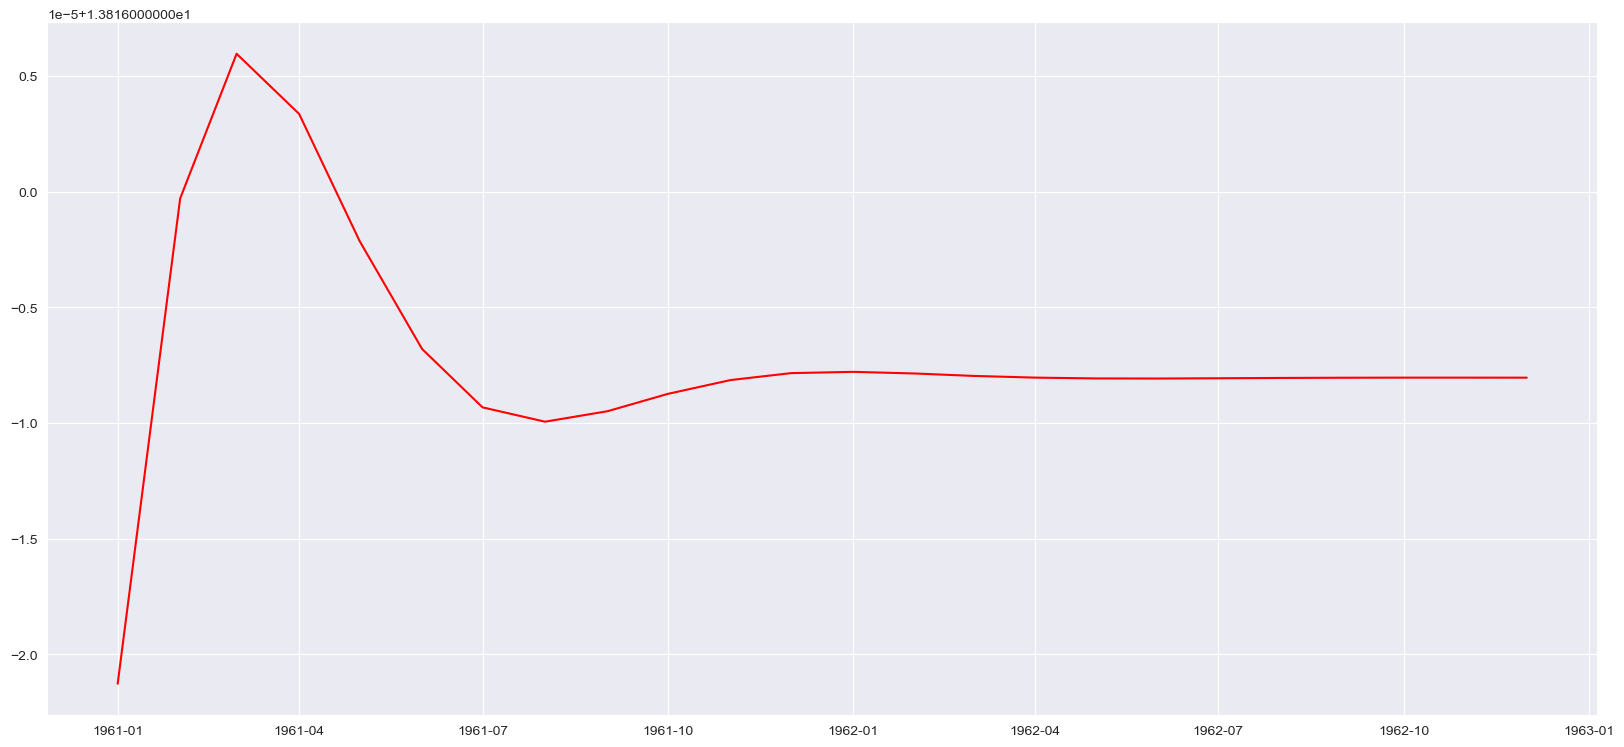

In [35]:
# Call figure() and plot() on the plt
plt.figure(figsize=(20,9))
# plt.plot(y_log.diff())
plt.plot(forecast, color = 'red')
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [36]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 96
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()
print(date_range)

['1960-12-01', '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01', '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01', '1963-01-01', '1963-02-01', '1963-03-01', '1963-04-01', '1963-05-01', '1963-06-01', '1963-07-01', '1963-08-01', '1963-09-01', '1963-10-01', '1963-11-01', '1963-12-01', '1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01', '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01', '1964-09-01', '1964-10-01', '1964-11-01', '1964-12-01', '1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01', '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01', '1965-09-01', '1965-10-01', '1965-11-01', '1965-12-01', '1966-01-01', '1966-02-01', '1966-03-01', '1966-04-01', '1966-05-01', '1966-06-01', '1966-07-01', '1966-08-01', '1966-09-01', '1966-10-01', '1966

In [37]:
# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd

future_months = pd.DataFrame(date_range, columns = ['Month'])
# Let's now convert the 'Month' column to a datetime object with to_datetime

future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast
future_months.head()

,Prediction
Month,
1960-12-01,NaN
1961-01-01,13.815979
1961-02-01,13.816000
1961-03-01,13.816006
1961-04-01,13.816003


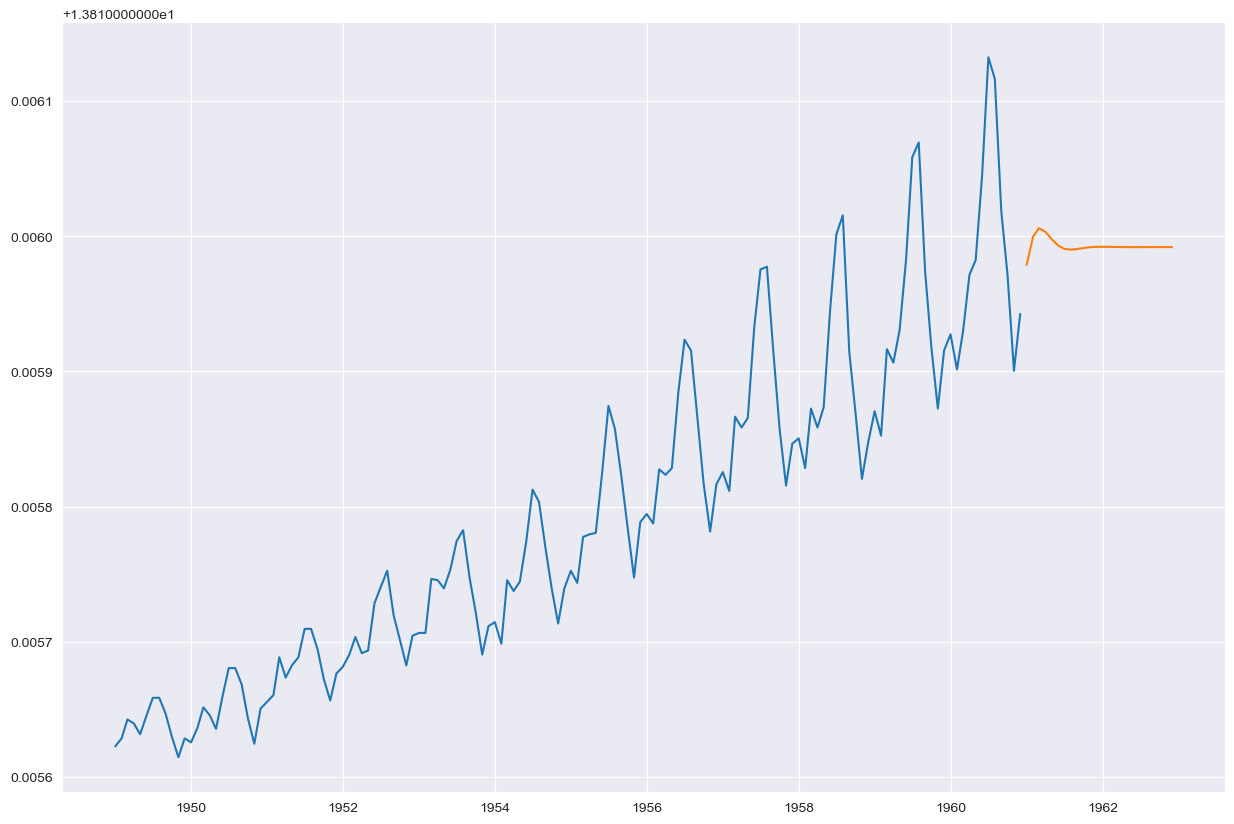

In [38]:

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y_log)
plt.plot(y_log['Nov 1960'].append(future_months['Prediction']))
plt.show()

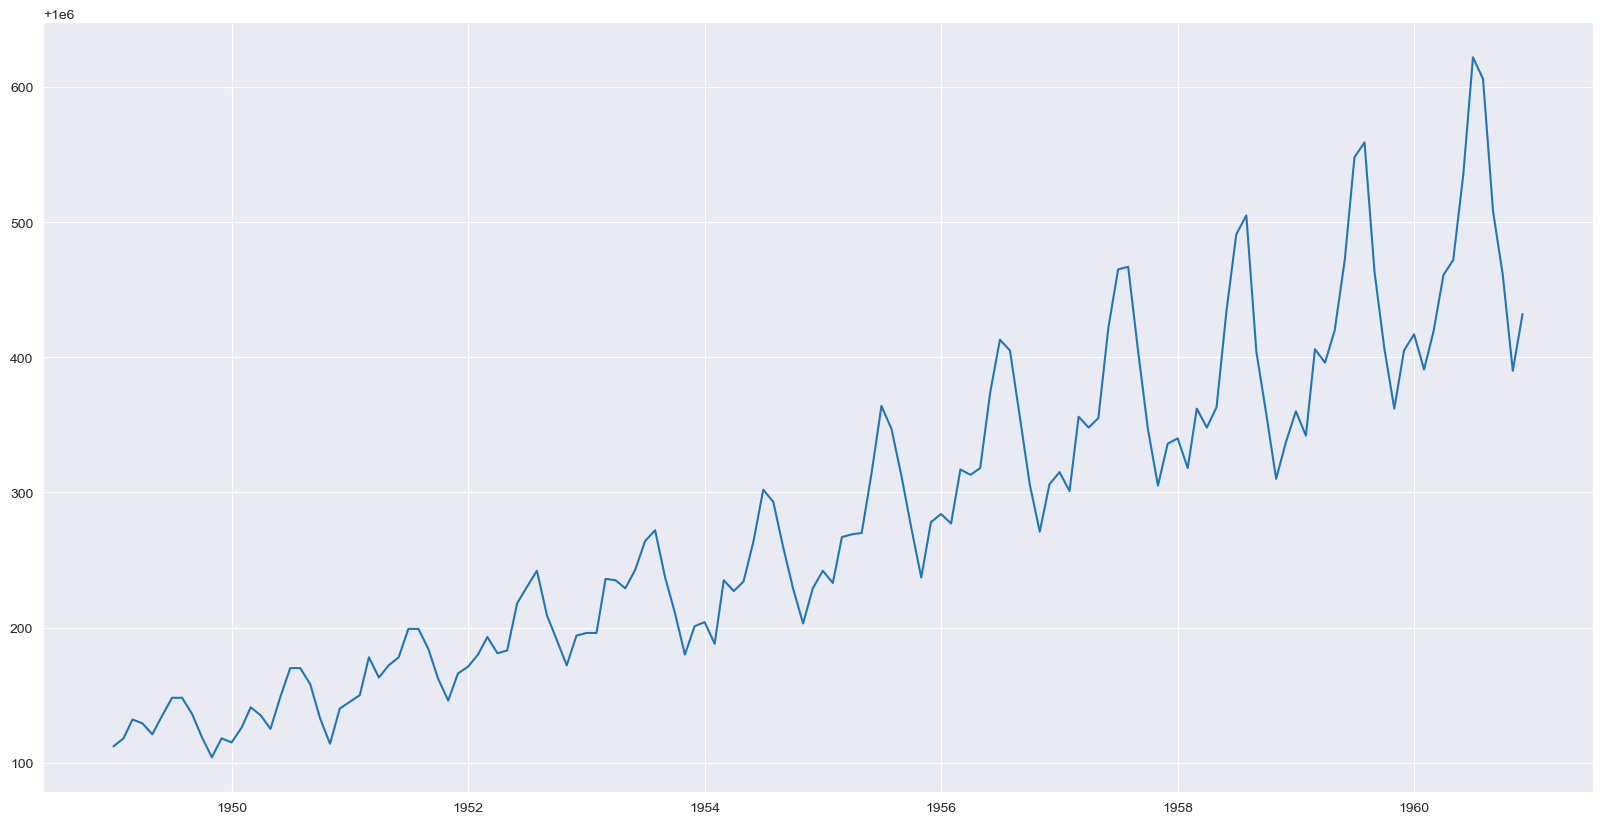

In [39]:
# Now plot the original variable y 
# Use the same functions as before
plt.figure(figsize=(20,10))
plt.plot(y)
plt.show()

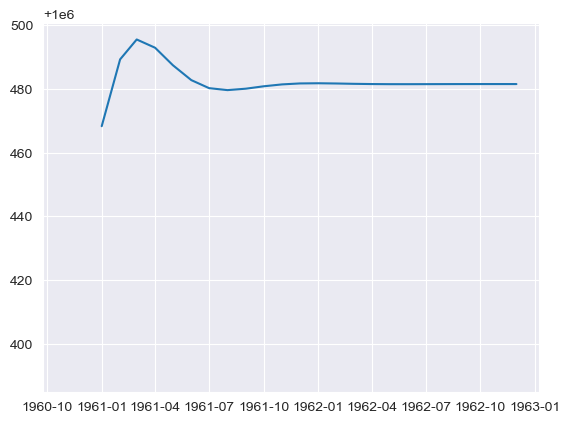

In [40]:
plt.plot(np.exp(y_log['Nov 1960'].append(future_months['Prediction'])))
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one.